# Project 3
## Python Reddit API
Differencing Marriage subreddit vs Dating Subreddit <br>
Fitting Logistic Regression and Random Forest models with characteristics of posts' texts and posts' texts

### Imports

In [344]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.compose import ColumnTransformer

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

import warnings
warnings.filterwarnings('ignore')

### Reading and getting to know the data

In [230]:
# reading the dataset of dating and marriage subreddits - generated in 'scraping'
date_marry = pd.read_csv('../output/marriage_dating.csv')
date_marry.drop(columns = 'Unnamed: 0', inplace = True)

In [231]:
date_marry.head()

,title,self_text,subreddit
0,What does it mean when a girl says I don’t fee...,I had a date yesterday and I thought it was ok...,dating
1,why do some guys get hurt/bothered if you slee...,My ex recently found out I hooked up with some...,dating
2,Worst era to ever date in as a guy.,Is there a single (attractive) young woman (ea...,dating
3,"Why do some men hate ""Vanilla women""?","Hiya. Earlier today I got called a ""vanilla wo...",dating
4,Guys the Victim mentality WONT help you,I've been couple of years in this sub and that...,dating


In [232]:
date_marry.isna().sum()

title        0
self_text    0
subreddit    0
dtype: int64

In [233]:
# binarizing target variable: subreddit
# 'dating' is 1, 'marriage' is 0
date_marry['subreddit'] = (date_marry['subreddit']=='dating')*1

In [234]:
date_marry.head()

,title,self_text,subreddit
0,What does it mean when a girl says I don’t fee...,I had a date yesterday and I thought it was ok...,1
1,why do some guys get hurt/bothered if you slee...,My ex recently found out I hooked up with some...,1
2,Worst era to ever date in as a guy.,Is there a single (attractive) young woman (ea...,1
3,"Why do some men hate ""Vanilla women""?","Hiya. Earlier today I got called a ""vanilla wo...",1
4,Guys the Victim mentality WONT help you,I've been couple of years in this sub and that...,1


In [235]:
# Checking the size of the dataset
date_marry.shape

(7658, 3)

In [236]:
# Checking if there are duplicates
date_marry.drop_duplicates(inplace=True)
date_marry.shape

(7658, 3)

In [237]:
# Checking the baseline of the dataset
date_marry['subreddit'].value_counts(normalize=True)

1    0.599373
0    0.400627
Name: subreddit, dtype: float64

# Special characters - are there differences between subreddits?

### Counting special characters and checking if there are differences between subreddits

In [238]:
# code adapted from stack overflow
# https://stackoverflow.com/questions/59687650/how-to-count-special-chars-in-column-in-pandas
date_marry["special_characters"] = date_marry["self_text"].apply(lambda x: sum(not c.isalpha() for c in x ))
date_marry["special_characters"]

0        155
1         53
2         54
3        141
4        239
        ... 
7653     111
7654    1019
7655      14
7656     516
7657     117
Name: special_characters, Length: 7658, dtype: int64

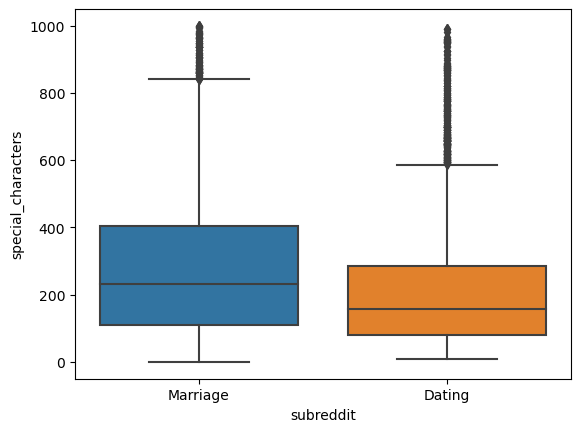

In [239]:
sns.boxplot(x="subreddit", y="special_characters",data=date_marry[date_marry['special_characters']<1000])
plt.xticks([0, 1], ['Marriage', 'Dating']);

In [240]:
date_marry.groupby('subreddit')['special_characters'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
0,3068.0,338.818123,363.127990,0.0,115.75,242.0,441.0,4660.0
1,4590.0,227.426797,236.988225,8.0,82.00,161.0,292.0,4286.0


In [241]:
most_special_characters = date_marry[date_marry["special_characters"]==4660]['self_text']
for string in most_special_characters:
    print(string)

**Final Edit I promise!** 

*Don't worry y'all, I'll be a distant part of your short-term internet memory in like 12 hours.* 

*Trigger warning- the following portion will add another 300 words or so. If you're averse to reading long things, go to Twitter.* 

For those (there were a tiny few) who enjoyed my writing or my "candor," feel free to "follow" me on Reddit. I tend to fixate on a subject on Reddit about once a month, I write 2 to 3 pages on it, and then, typically, I get a mixture of temper tantrums, 'amen brothers' in my DMs, and angry people who read the first 25 words and assume they've read it all. 

For those who insisted on calling me names, using insulting adjectives, or (my least favorite) using all the vocab they learned in Berne Brown's TED Talk to psychoanalyze me while they are angrily typing away on their phones, what do you think your purpose was? Those of us who've (not proud of this) argued with trump supporters or AOC supporters or anti-vaxxers or steelers fans

The post that has the highest number of special characters is maybe just too long... maybe that's the difference between the subreddits... let's see the proportion of special characters on the texts' lenghts

In [242]:
date_marry['text_length'] = date_marry['self_text'].apply(lambda x: len(x))
date_marry['percent_special_characters'] = date_marry["special_characters"]/date_marry["text_length"]

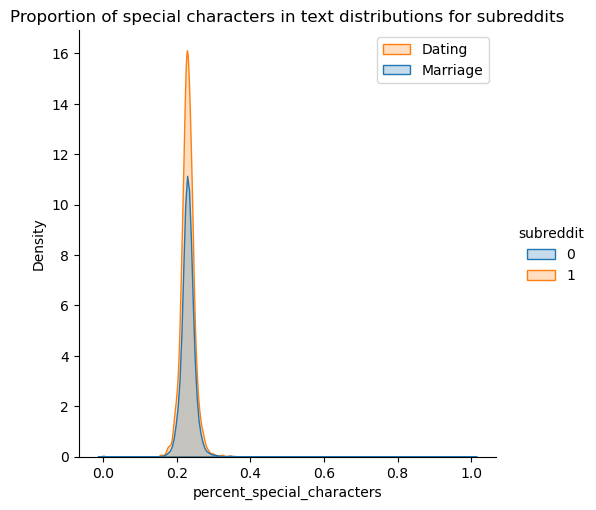

In [243]:
sns.displot(date_marry, x="percent_special_characters", hue="subreddit", kind="kde", fill=True)
plt.legend(['Dating', 'Marriage'])
plt.title('Proportion of special characters in text distributions for subreddits');

> The distribution of percentage of special characters in the posts' texts dont seem to be different between subreddits... it can be a sign that this new variable would not make a good predictor after all...

 # Analyzing some specific words
Let's explore some words that can be very specific to each one of the subreddits

In [244]:
husband = date_marry['title'].str.lower().str.contains('husband')
wife = date_marry['title'].str.lower().str.contains('wife')
wedding = date_marry['title'].str.lower().str.contains('wedding')
marry = date_marry['title'].str.lower().str.contains('marry')
date_marry['marriage_keywords'] = (husband | wife | wedding | marry)
date_marry['marriage_keywords'] = date_marry['marriage_keywords'].astype(int)

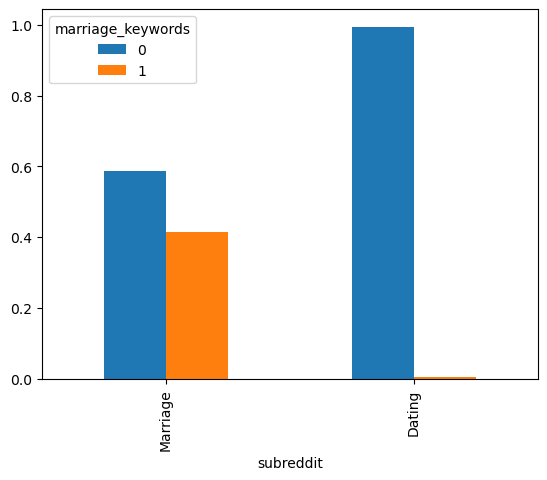

In [245]:
date_marry.groupby('subreddit')['marriage_keywords'].value_counts(normalize=True).unstack(level = 1).plot(kind = 'bar')
plt.xticks([0, 1], ['Marriage', 'Dating']);


From the graph above, it is possible to see that aproximately 40% of marriage subreddits have "husband", "wife", "wedding" or "marry" in the title, while almost 100% of the dating's subreddit titles do not mention these words. This could facilitate a lot the model to predict from which subreddit the post came from... first, let's see how the model performs. If it's too easy, maybe i'll make it more challenging by removing words that are too specific of the subreddits ;)

In [246]:
boyfriend = date_marry['title'].str.lower().str.contains('boyfriend')
girlfriend = date_marry['title'].str.lower().str.contains('girlfriend')
dating = date_marry['title'].str.lower().str.contains('dating')
bf = date_marry['title'].str.lower().str.contains('bf')
gf = date_marry['title'].str.lower().str.contains('gf')
date_marry['dating_keywords'] = (boyfriend | girlfriend | bf | gf | dating)
date_marry['dating_keywords'] = date_marry['dating_keywords'].astype(int)

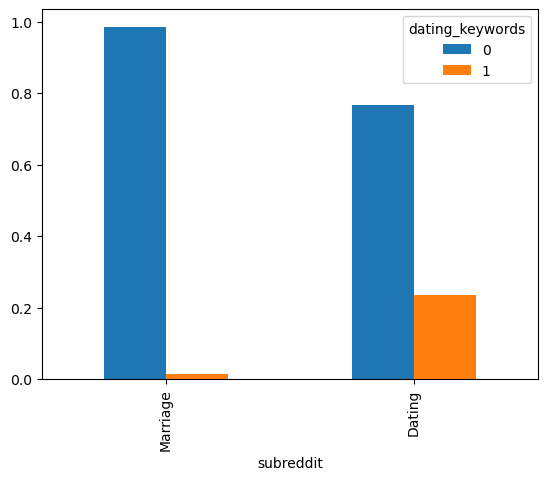

In [247]:
date_marry.groupby('subreddit')['dating_keywords'].value_counts(normalize=True).unstack(level = 1).plot(kind = 'bar')
plt.xticks([0, 1], ['Marriage', 'Dating']);

Boyfriend, girlfriend and dating dont seem to be so specific as marriage keywords are... <br>
Beyond the obvious, what are the types of problems or questions they have with their respective person of interest?

## Most common words, with stop words

In [248]:
# Redefine training and testing sets.
X = date_marry[date_marry['subreddit']==0]['self_text']
y = date_marry['subreddit']
cvec = CountVectorizer()

In [249]:
X = cvec.fit_transform(X)

Text(0.5, 1.0, 'Marriage most common words')

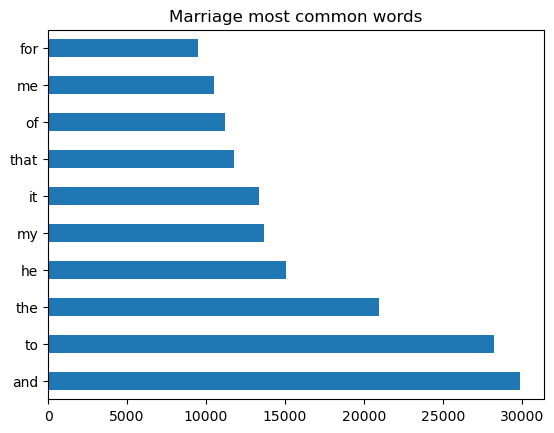

In [250]:
X_df = pd.DataFrame(X.todense(), columns = cvec.get_feature_names_out())
X_df.sum().sort_values(ascending=False)[:10].plot(kind='barh')
plt.title('Marriage most common words')

In [251]:
# Redefine training and testing sets.
X = date_marry[date_marry['subreddit']==1]['self_text']
y = date_marry['subreddit']
cvec = CountVectorizer()

In [252]:
X = cvec.fit_transform(X)

Text(0.5, 1.0, 'Dating most common words')

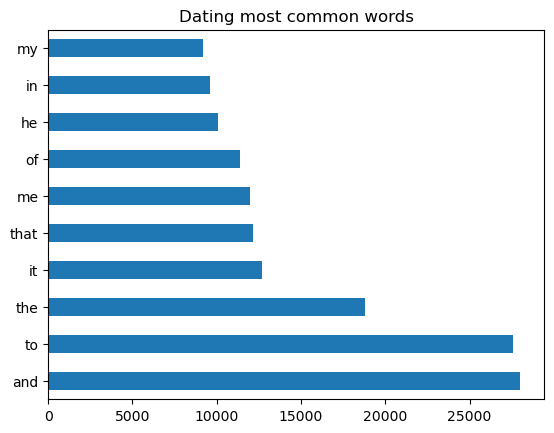

In [253]:
X_df = pd.DataFrame(X.todense(), columns = cvec.get_feature_names_out())
X_df.sum().sort_values(ascending=False)[:10].plot(kind='barh')
plt.title('Dating most common words')

Plotting the 10 most common words considering the stop words dont tell us much about the words too specific to each of the subreddits... maybe without the stop words we can see something

## Most common words, without stop words

In [254]:
# Redefine training and testing sets.
X = date_marry[date_marry['subreddit']==0]['self_text']
y = date_marry['subreddit']
cvec = CountVectorizer(stop_words='english')

In [255]:
X = cvec.fit_transform(X)

Text(0.5, 1.0, 'Marriage most common words')

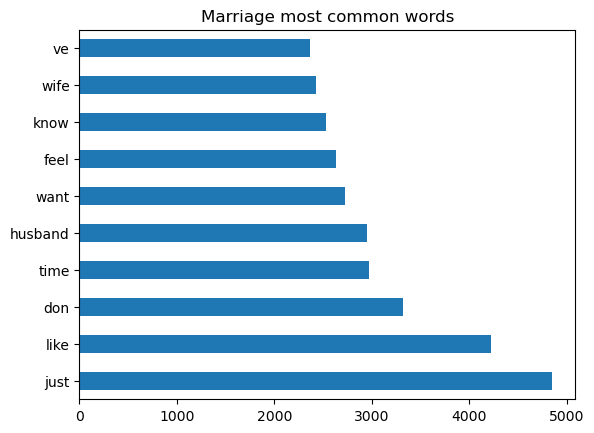

In [256]:
X_df = pd.DataFrame(X.todense(), columns = cvec.get_feature_names_out())
X_df.sum().sort_values(ascending=False)[:10].plot(kind='barh')
plt.title('Marriage most common words')

In [257]:
# Redefine training and testing sets.
X = date_marry[date_marry['subreddit']==1]['self_text']
y = date_marry['subreddit']
cvec = CountVectorizer(stop_words='english')

In [258]:
X = cvec.fit_transform(X)

Text(0.5, 1.0, 'Dating most common words')

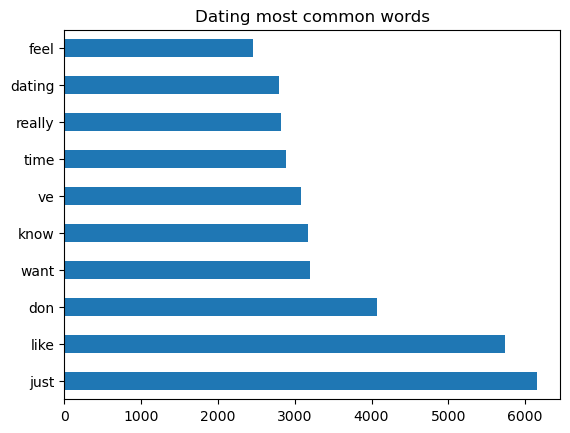

In [259]:
X_df = pd.DataFrame(X.todense(), columns = cvec.get_feature_names_out())
X_df.sum().sort_values(ascending=False)[:10].plot(kind='barh')
plt.title('Dating most common words')

When not considering stop words, two marriage keywords that were explored earlier in the barplots are actually in the top 10 most common words in marriage's posts' texts <br>
As mentioned above, after checking models' performances, maybe these will get removed to make it more challenging ;)

# Upper and lower characters

In [260]:
date_marry['upper'] = date_marry['self_text'].apply(lambda x: sum(1 for char in x if char.isupper()))
date_marry['lower'] = date_marry['self_text'].apply(lambda x: sum(1 for char in x if char.islower()))
date_marry['up_low'] = date_marry['upper']/date_marry['lower']
date_marry['up_low'] = date_marry['up_low'].apply(lambda x: max(x, 0))

In [261]:
date_marry['up_low'].isna().sum()

1

In [262]:
date_marry[date_marry['up_low'].isna()]['self_text']

4335    .
Name: self_text, dtype: object

In [263]:
# Dropping the "text" that is actually a dot
date_marry.dropna(subset='up_low', inplace = True)

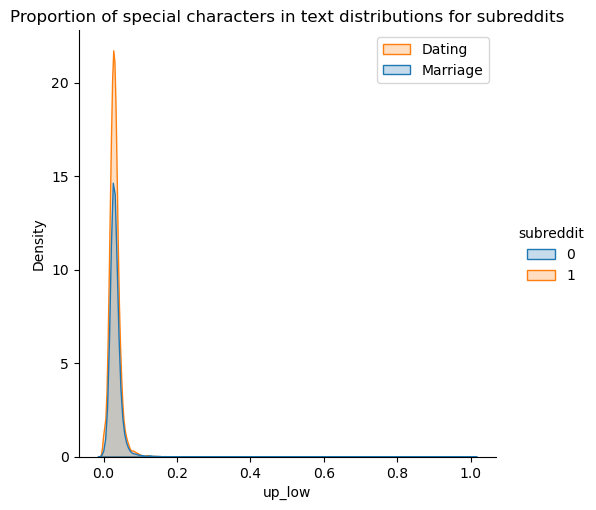

In [264]:
sns.displot(date_marry, x="up_low", hue="subreddit", kind="kde", fill=True)
plt.legend(['Dating', 'Marriage'])
plt.title('Proportion of special characters in text distributions for subreddits');

# Preprocessing posts' texts

After getting the information of texts that goes beyond its content (special characters), let's pre process it. <br>
That is, make it lower case, remove special characters and lemmatize it <br>
This way, we do not overload countervectorize with words that could be the same but put in different columns <br>
Since there is already information on the special characters and lower and uppercase letters, these will be removed. Simplicity is improved, while posts' text content is maintained.

In [265]:
# preprocessing the text
def lower_case(text):
    return text.lower()

# functin inspired in chatgpt
def remove_special(text):
    # Remove digits and special characters except whitespace
    cleaned_text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Remove extra whitespaces
    cleaned_text = " ".join(cleaned_text.split())
    return cleaned_text


# do i need to use lower_case inside lemmatize or the preprocessing follows the order?
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    sw = stopwords.words("english")
    final_text = [lemmatizer.lemmatize(word) if word not in sw else word for word in text.split()]
    return ' '.join(final_text)


def preprocess_text(text):
    transformed_data = lower_case(text)
    transformed_data = remove_special(transformed_data)
    transformed_data = lemmatize_text(transformed_data)
    return transformed_data

In [266]:
date_marry["self_text"] = date_marry["self_text"].apply(lambda x: preprocess_text(x))

# Getting the sentiment analysis of the posts' descriptions

In [267]:
# Creating the columns with the negative, positive, neutral and compound scores
sa = SentimentIntensityAnalyzer()
date_marry['compounds'] = date_marry['self_text'].apply(lambda r: sa.polarity_scores(r)['compound'])
date_marry['neg'] = date_marry['self_text'].apply(lambda r: sa.polarity_scores(r)['neg'])
date_marry['neu'] = date_marry['self_text'].apply(lambda r: sa.polarity_scores(r)['neu'])
date_marry['pos'] = date_marry['self_text'].apply(lambda r: sa.polarity_scores(r)['pos'])

In [268]:
# Checking the new columns
date_marry[['compounds', 'neg', 'neu', 'pos']]

,compounds,neg,neu,pos
0,0.9481,0.037,0.790,0.173
1,-0.3253,0.153,0.718,0.130
2,0.7096,0.000,0.843,0.157
3,0.9722,0.016,0.767,0.217
4,-0.9301,0.176,0.717,0.107
...,...,...,...,...
7653,-0.8454,0.165,0.745,0.090
7654,-0.9024,0.096,0.813,0.091
7655,0.0000,0.000,1.000,0.000
7656,0.2218,0.028,0.940,0.032


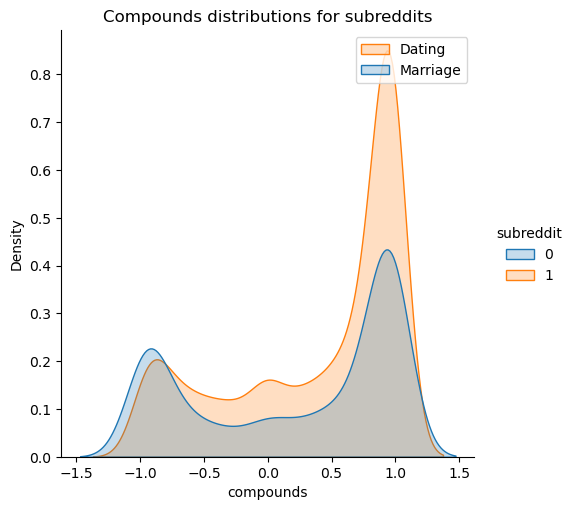

In [269]:
sns.displot(date_marry, x="compounds", hue="subreddit", kind="kde", fill=True)
plt.legend(['Dating', 'Marriage'])
plt.title('Compounds distributions for subreddits');

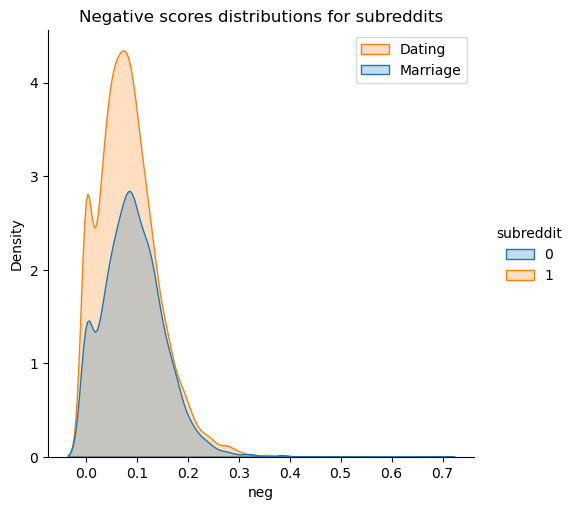

In [270]:
sns.displot(date_marry, x="neg", hue="subreddit", kind="kde", fill=True)
plt.legend(['Dating', 'Marriage'])
plt.title('Negative scores distributions for subreddits');

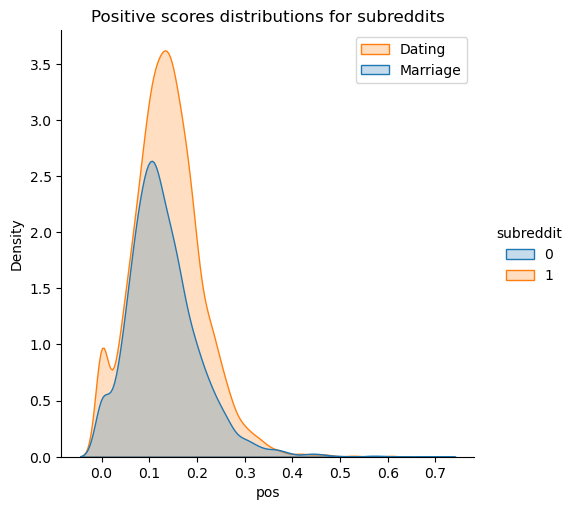

In [271]:
sns.displot(date_marry, x="pos", hue="subreddit", kind="kde", fill=True)
plt.legend(['Dating', 'Marriage'])
plt.title('Positive scores distributions for subreddits');

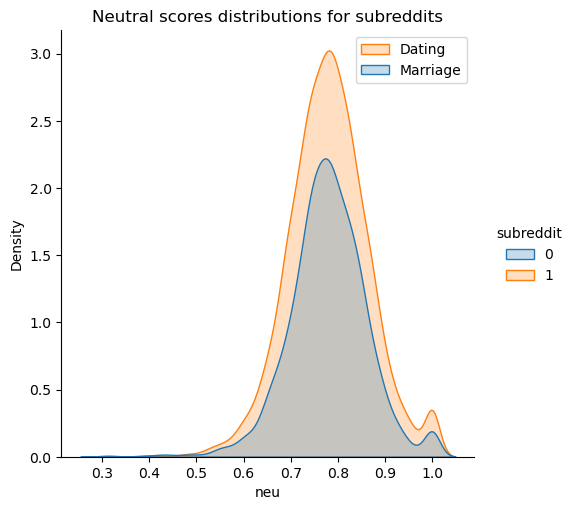

In [272]:
sns.displot(date_marry, x="neu", hue="subreddit", kind="kde", fill=True)
plt.legend(['Dating', 'Marriage'])
plt.title('Neutral scores distributions for subreddits');

> Some Sentiment Analysis scores seem to be a little different among the subreddits...
Maybe it helps the models.

# Text length

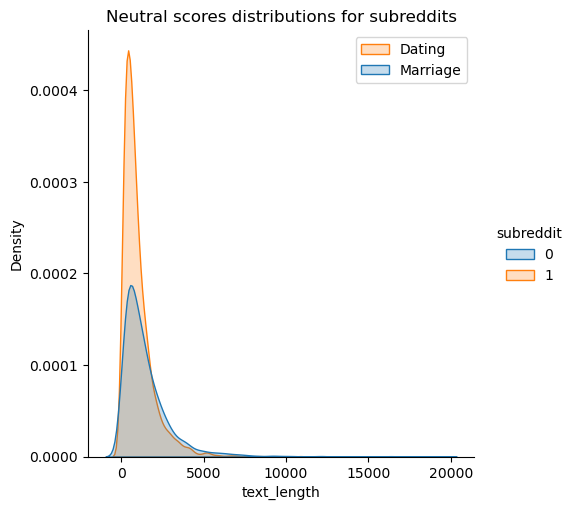

In [273]:
sns.displot(date_marry, x="text_length", hue="subreddit", kind="kde", fill=True)
plt.legend(['Dating', 'Marriage'])
plt.title('Neutral scores distributions for subreddits');

> Text length of marriage posts seem more disperse than dating posts. Maybe this new variable will help the model to predict

# Numerical columns and Logistic regression

These new numerical columns don't seem to be different among subreddits, so maybe they arent good predictors of which subreddit the post came from... let's try a logistic regression with these variables to see if it would give a better accuracy than the baseline...

In [274]:
date_marry.dtypes

title                          object
self_text                      object
subreddit                       int64
special_characters              int64
text_length                     int64
percent_special_characters    float64
marriage_keywords               int64
dating_keywords                 int64
upper                           int64
lower                           int64
up_low                        float64
compounds                     float64
neg                           float64
neu                           float64
pos                           float64
dtype: object

In [275]:
date_marry.select_dtypes(include=['int64', 'float64']).columns

Index(['subreddit', 'special_characters', 'text_length',
       'percent_special_characters', 'marriage_keywords', 'dating_keywords',
       'upper', 'lower', 'up_low', 'compounds', 'neg', 'neu', 'pos'],
      dtype='object')

In [276]:
# splitting data
numericals = list(date_marry.select_dtypes(include=['int64', 'float64']).columns)
numericals.remove('subreddit')
X = date_marry[numericals]
y = date_marry['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1906)

In [277]:
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train, y_train)
logreg.score(X_train, y_train)

0.7725531173807035

> The numericals columns ended up being better predictors than the baseline in logistic regression! Lets keep it

# Pipe 1 - Fitting a random forest
## on the numericals columns and the posts' text

In [278]:
# Prepare your data
X = date_marry[['self_text', 'special_characters', 'text_length',
       'percent_special_characters', 'upper', 'lower', 'up_low', 'compounds',
       'neg', 'neu', 'pos']]
y = date_marry['subreddit']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1906)

In [279]:
# Define the column transformer
column_transformer = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(), 'self_text'),
        ('sc', StandardScaler(), ['special_characters', 'text_length',
       'percent_special_characters', 'upper', 'lower', 'up_low', 'compounds',
       'neg', 'neu', 'pos'])
    ])

In [280]:
# Create the pipeline
pipe_1 = Pipeline([
    ('preprocessing', column_transformer),
    ('model', RandomForestClassifier())
])

In [281]:
pipe_1_params = {
    'preprocessing__text__stop_words': [None, "english"],
    'preprocessing__text__ngram_range': [(1, 1), (2, 2), (3,3)],
}

In [282]:
# Instantiate RandomizedSearch.
rand_gs_rand_for = RandomizedSearchCV(pipe_1, 
                     param_distributions= pipe_1_params,
                     cv = 5, n_jobs = 4, n_iter=6)

In [283]:
rand_gs_rand_for.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('text',
                                                                               CountVectorizer(),
                                                                               'self_text'),
                                                                              ('sc',
                                                                               StandardScaler(),
                                                                               ['special_characters',
                                                                                'text_length',
                                                                                'percent_special_characters',
                                                                                'upper',
                                                                                'lower',
                                                                                'up_low',
                                                                                'compounds',
                                                                                'neg',
                                                                                'neu',
                                                                                'pos'])])),
                                             ('model',
                                              RandomForestClassifier())]),
                   n_iter=6, n_jobs=4,
                   param_distributions={'preprocessing__text__ngram_range': [(1,
                                                                              1),
                                                                             (2,
                                                                              2),
                                                                             (3,
                                                                              3)],
                                        'preprocessing__text__stop_words': [None,
                                                                            'english']})

In [284]:
rand_gs_rand_for.score(X_test, y_test)

0.9138381201044387

# Pipe 2 - Fitting a logistic regression
## on the numericals columns and the posts' text

In [353]:
# Prepare your data
X = date_marry[['self_text', 'special_characters', 'text_length',
       'percent_special_characters', 'upper', 'lower', 'up_low', 'compounds',
       'neg', 'neu', 'pos']]
y = date_marry['subreddit']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1906)

In [354]:
# Define the column transformer
column_transformer = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(), 'self_text'),
        ('sc', StandardScaler(), ['special_characters', 'text_length',
       'percent_special_characters', 'upper', 'lower', 'up_low', 'compounds',
       'neg', 'neu', 'pos'])
    ])

In [355]:
# Create the pipeline
pipe_2 = Pipeline([
    ('preprocessing', column_transformer),
    ('model', LogisticRegression(max_iter=2000))
])

In [356]:
pipe_2_params = {
    'preprocessing__text__stop_words': [None, "english"],
    'preprocessing__text__ngram_range': [(1, 1), (1, 2), (3,3)],
    'model__C': [1.0, 0.8, 0.5],
    'model__penalty': ['l2']
}

In [357]:
# Instantiate GridSearchCV.
gs_logreg = GridSearchCV(pipe_2,
                     param_grid = pipe_2_params,
                     cv = 5, n_jobs = 4)

In [358]:
gs_logreg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('text',
                                                                         CountVectorizer(),
                                                                         'self_text'),
                                                                        ('sc',
                                                                         StandardScaler(),
                                                                         ['special_characters',
                                                                          'text_length',
                                                                          'percent_special_characters',
                                                                          'upper',
                                                                          'lower',
                                                                          'up_low',
                                                                          'compounds',
                                                                          'neg',
                                                                          'neu',
                                                                          'pos'])])),
                                       ('model',
                                        LogisticRegression(max_iter=2000))]),
             n_jobs=4,
             param_grid={'model__C': [1.0, 0.8, 0.5], 'model__penalty': ['l2'],
                         'preprocessing__text__ngram_range': [(1, 1), (1, 2),
                                                              (3, 3)],
                         'preprocessing__text__stop_words': [None, 'english']})

Accuracy on unseen data:

In [359]:
gs_logreg.score(X_test, y_test)

0.9295039164490861

In [360]:
preds = gs_logreg.predict(X_test)

Best parameters for logistic regression:

In [361]:
gs_logreg.best_params_

{'model__C': 0.5,
 'model__penalty': 'l2',
 'preprocessing__text__ngram_range': (1, 2),
 'preprocessing__text__stop_words': 'english'}

# Pipe 3 - Fitting a logistic regression without keywords
## on the numericals columns and the posts' text
Since logistic regression had a better accuracy, let's try these without the keywords to see how it changes the accuracy <br>
Since english stop words were the best parameter for stop words, lets use it and add the keywords to see how it affects accuracy

In [345]:
# Prepare your data
X = date_marry[['self_text', 'special_characters', 'text_length',
       'percent_special_characters', 'upper', 'lower', 'up_low', 'compounds',
       'neg', 'neu', 'pos']]
y = date_marry['subreddit']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1906)

In [346]:
# creating list of stop words with keywords
sw = stopwords.words("english")
sw.append('husband')
sw.append('wife')
sw.append('dating')

In [347]:
# Define the column transformer
column_transformer = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(stop_words=sw), 'self_text'),
        ('sc', StandardScaler(), ['special_characters', 'text_length',
       'percent_special_characters', 'upper', 'lower', 'up_low', 'compounds',
       'neg', 'neu', 'pos'])
    ])

In [348]:
# Create the pipeline
pipe_3 = Pipeline([
    ('preprocessing', column_transformer),
    ('model', LogisticRegression(max_iter=2000))
])

In [349]:
pipe_3_params = {
    'preprocessing__text__ngram_range': [(1, 1), (1, 2), (3,3)],
    'model__C': [1.0, 0.8, 0.5],
    'model__penalty': ['l2']
}

In [350]:
# Instantiate GridSearchCV.
gs_logreg_2 = GridSearchCV(pipe_3,
                     param_grid = pipe_3_params,
                     cv = 5, n_jobs = 4)

In [351]:
gs_logreg_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('text',
                                                                         CountVectorizer(stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                                                                                                     'ours',
                                                                                                     'ourselves',
                                                                                                     'you',
                                                                                                     "you're",
                                                                                                     "you've",
                                                                                                     "you'll",
                                                                                                     "you'd",
                                                                                                     'your',
                                                                                                     'yours',
                                                                                                     'yourself',
                                                                                                     'yourselves',
                                                                                                     'he',
                                                                                                     'him',
                                                                                                     'his',
                                                                                                     'himself',
                                                                                                     'she',
                                                                                                     "she's",
                                                                                                     'her',
                                                                                                     'hers',
                                                                                                     'herself',
                                                                                                     'it',
                                                                                                     "it's",
                                                                                                     'its',
                                                                                                     'itself', ...]),
                                                                         'self_text'),
                                                                        ('sc',
                                                                         StandardScaler(),
                                                                         ['special_characters',
                                                                          'text_length',
                                                                          'percent_special_characters',
      

In [352]:
gs_logreg_2.score(X_test, y_test)

0.8976501305483029

# Confusion Matrix of Best Model

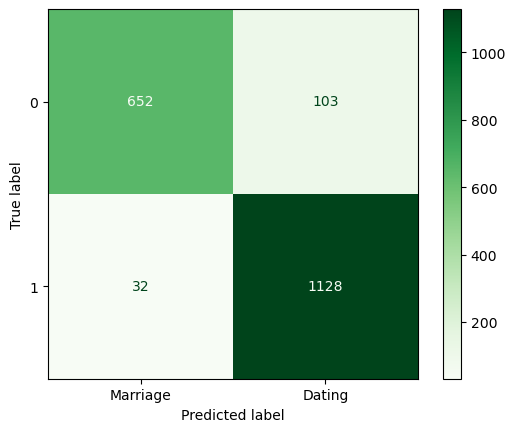

In [364]:
ConfusionMatrixDisplay.from_estimator(gs_logreg, X_test, y_test, cmap='Greens')
plt.xticks([0, 1], ['Marriage', 'Dating']);

In [363]:
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           0     0.9532    0.8636    0.9062       755
           1     0.9163    0.9724    0.9435      1160

    accuracy                         0.9295      1915
   macro avg     0.9348    0.9180    0.9249      1915
weighted avg     0.9309    0.9295    0.9288      1915



Since none of the groups needs more help than the other - married and single people are treated the same way - the metric of interest i the accuracy, which was 92.9%. This could be improved if more data were collected.

> # Conclusions

Logistic Regression had a better accuracy score, so between both models it is the best to use. <br>
<br>
When removing the keywords found in top 10 most common words of both groups, the accuracy decreased by 3%. Their differences goes beyond that and should be further analyzed, as looking on some more nuanced characteristics in common.